In [12]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx


In [13]:
a = np.load('/Users/caro/Desktop/thesis_project/clustering/adjacency_matrices/normalized_filtered_df.npy')

# Load data
all_viajes = pd.read_csv('/Users/caro/Desktop/thesis_project/mobility_data/VIAJES/all_viajes_month_0322.csv')
filtered_df = all_viajes.loc[(all_viajes['actividad_origen'] == 'casa')] # filtering only home origin trips
income = gpd.read_file('/Users/caro/Desktop/thesis_project/segregation_indices/data/processed/geometries_and_income.geojson')


In [35]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

In [36]:
# Define graph based on OD trips including normalisation by population 
def define_graph(df, population_df=None, NORMALISE_BY_POP=False, remove_weak_edges=False, threshold=0.1):
    """
    Define a directed graph from a DataFrame with trip counts and optional population normalization.

    Parameters:
    - df: DataFrame containing 'origen', 'destino', and trip data.
    - population_df: DataFrame containing district population with 'district' and 'population' columns.
    - NORMALISE_BY_POP: Boolean, if True, normalizes trip counts by the population of the origin district.
    - remove_weak_edges: Boolean, if True, removes edges with normalized weight below the threshold.
    - threshold: Float, the minimum normalized weight to include an edge.

    Returns:
    - G: A directed graph (networkx.DiGraph).
    - trip_counts: DataFrame with trip count and normalized trip count.
    """
    G = nx.DiGraph()

    # Group by origin and destination, and aggregate trip counts
    trip_counts = df.groupby(['origen', 'destino']).size().reset_index(name='trip_count')

    # Normalize by population if the flag is set
    if NORMALISE_BY_POP and population_df is not None:
        # Merge population data into the trip_counts DataFrame
        trip_counts = trip_counts.merge(population_df, left_on='origen', right_on='ID', how='left')
        # Normalize trip counts by population of the origin district
        trip_counts['norm_trip_count'] = trip_counts['trip_count'] / trip_counts['Population']
        trip_counts.drop(columns=['ID'], inplace=True)  # removing extra columns
        normalization_column = 'norm_trip_count'
    else:
        normalization_column = 'trip_count'

    # Normalize trip counts between 0 and 1
    trip_counts['scaled_trip_count'] = trip_counts['scaled_trip_count'] = scaler.fit_transform(trip_counts[[normalization_column]])
    # Option to remove weak edges below a threshold
    if remove_weak_edges:
        trip_counts = trip_counts[trip_counts['scaled_trip_count'] >= threshold]

    # Add edges to the graph with correct attributes
    for idx, row in trip_counts.iterrows():
        G.add_edge(
            row['origen'], 
            row['destino'], 
            weight=row['scaled_trip_count']
        )
    
    return G, trip_counts

In [37]:
district_counts = filtered_df['origen'].value_counts().reset_index()
district_counts.columns = ['ID', 'Population']

In [39]:
G, trip_counts_norm = define_graph(filtered_df, district_counts, NORMALISE_BY_POP=True, remove_weak_edges=False, threshold=0.2)

In [41]:
trip_counts_norm.groupby('origen')[['norm_trip_count', 'scaled_trip_count']].sum()

,norm_trip_count,scaled_trip_count
origen,,
2807901,1.0,4.08902
2807902,1.0,4.08902
2807903,1.0,4.08902
2807904,1.0,4.08902
2807905,1.0,4.08902
2807906,1.0,4.08902
2807907,1.0,4.08902
2807908,1.0,4.08902
2807909,1.0,4.08902


In [28]:
trip_counts_norm

,origen,destino,trip_count,Population,norm_trip_count,scaled_trip_count
0,2807901,2807901,23450,229064,0.102373,0.458263
1,2807901,2807902,20538,229064,0.089661,0.397074
2,2807901,2807903,16117,229064,0.070360,0.304176
3,2807901,2807904,16966,229064,0.074067,0.322016
4,2807901,2807905,9214,229064,0.040225,0.159123
...,...,...,...,...,...,...
436,2807921,2807917,1108,131368,0.008434,0.006107
437,2807921,2807918,1976,131368,0.015042,0.037911
438,2807921,2807919,2121,131368,0.016145,0.043223
439,2807921,2807920,19764,131368,0.150448,0.689660


In [4]:
a.shape

(21, 21)

In [5]:
a

array([[0.45826336, 0.39707372, 0.30417557, 0.32201555, 0.15912334,
        0.13292022, 0.49650688, 0.17278174, 0.39219872, 0.28885715,
        0.26040565, 0.15128552, 0.08568317, 0.02020689, 0.08902422,
        0.09007487, 0.05105386, 0.04874244, 0.02501885, 0.07538683,
        0.06822142],
       [0.50370396, 0.42438418, 0.36446665, 0.16078462, 0.12300237,
        0.09636077, 0.18246091, 0.14768288, 0.25049401, 0.24788618,
        0.41679017, 0.41770813, 0.22620989, 0.03243761, 0.07954547,
        0.09869738, 0.08601289, 0.06569268, 0.03327212, 0.07407946,
        0.05734762],
       [0.43803158, 0.3556402 , 0.44746063, 0.47204266, 0.14684728,
        0.09844323, 0.21085557, 0.14475721, 0.12578036, 0.05331679,
        0.08628285, 0.0831715 , 0.46524994, 0.36043785, 0.1912612 ,
        0.09264805, 0.03923259, 0.07770882, 0.05557312, 0.0769488 ,
        0.06732974],
       [0.32687724, 0.09290913, 0.37850795, 0.46868191, 0.47855742,
        0.15182662, 0.43505244, 0.17713861, 0.1514670

In [7]:
np.sum(a[0])

np.float64(4.0890199670851315)

In [8]:
np.sum(a[1])

np.float64(4.0890199670851315)

In [9]:
np.sum(a[5])

np.float64(4.0890199670851315)

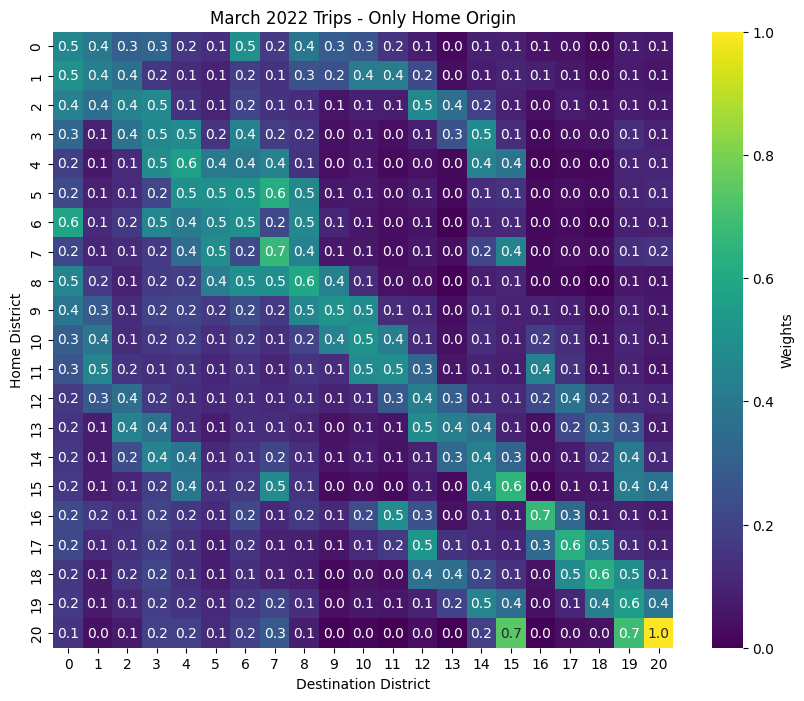

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(
    a, 
    annot=True, 
    cmap='viridis', 
    cbar_kws={'label': 'Weights'}, 
    fmt=".1f"
)
plt.title('March 2022 Trips - Only Home Origin')
plt.xlabel('Destination District')
plt.ylabel('Home District');

In [49]:
G = nx.DiGraph()
trip_counts = filtered_df.groupby(['origen', 'destino']).size().reset_index(name='trip_count')
trip_counts = trip_counts.merge(district_counts, left_on='origen', right_on='ID', how='left')
# Normalize trip counts by population of the origin district
trip_counts['norm_trip_count'] = trip_counts['trip_count'] / trip_counts['Population']
trip_counts.drop(columns=['ID'], inplace=True)  # removing extra columns

In [51]:
for idx, row in trip_counts.iterrows():
    G.add_edge(
        row['origen'], 
        row['destino'], 
        weight=row['norm_trip_count']
            )

In [52]:
from clustering.utils import get_adj_matrix
a = get_adj_matrix(G)

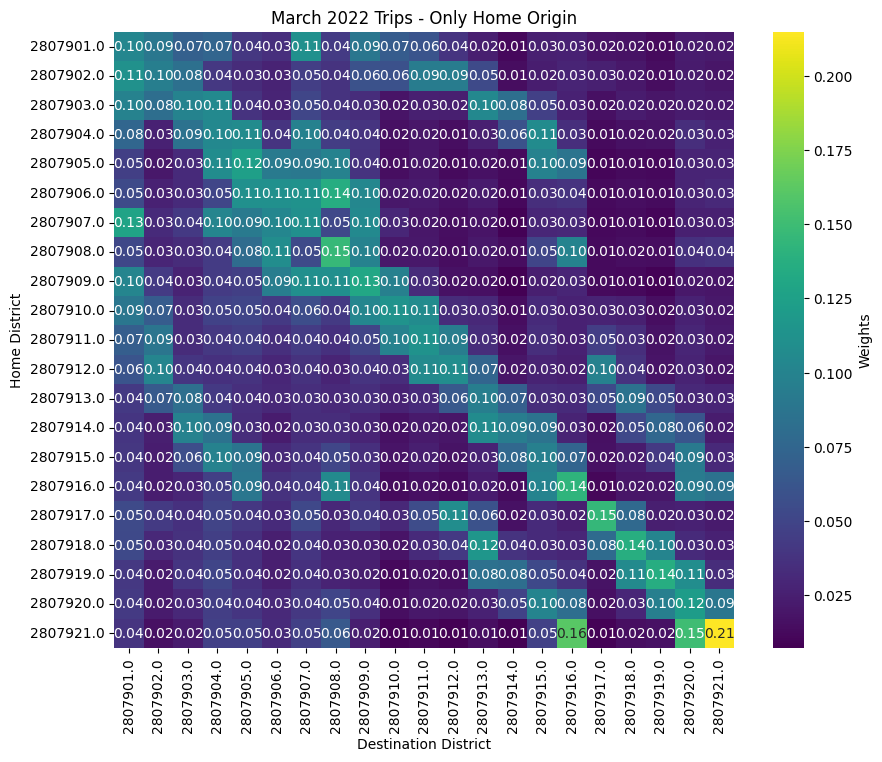

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(
    a, 
    annot=True, 
    cmap='viridis', 
    cbar_kws={'label': 'Weights'}, 
    fmt=".2f"
)
plt.title('March 2022 Trips - Only Home Origin')
plt.xlabel('Destination District')
plt.ylabel('Home District');